<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchsummary import summary
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

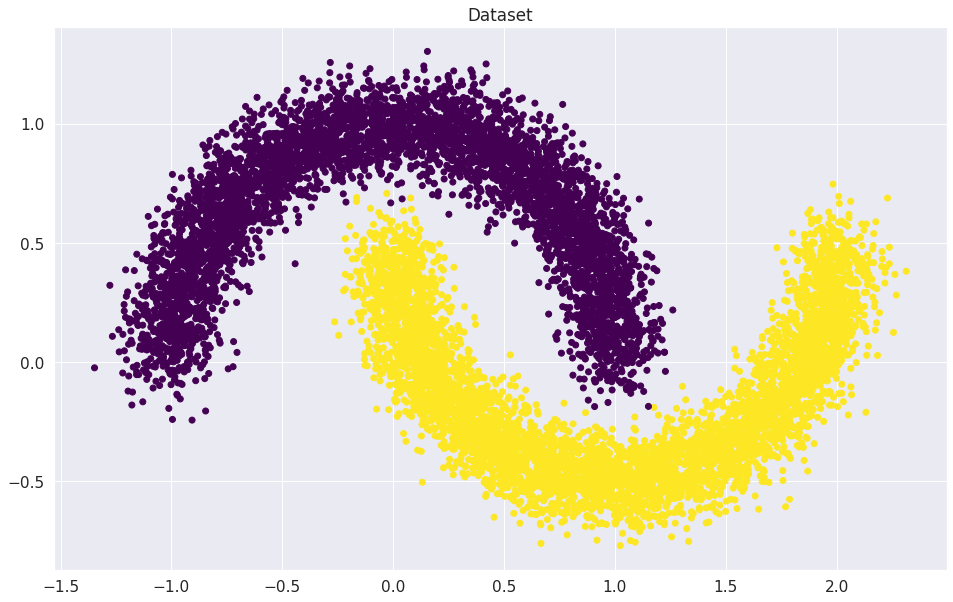

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train).view(-1, 1)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val).view(-1, 1)

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features), requires_grad=True) # YOUR CODE GOES HERE
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True) # YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights.t() # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [10]:
linear_regression.__dict__

{'_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_parameters': OrderedDict([('weights', Parameter containing:
               tensor([[1.0379, 2.4760]], requires_grad=True)),
              ('bias_term', Parameter containing:
               tensor([-0.1329], requires_grad=True))]),
 '_state_dict_hooks': OrderedDict(),
 'bias': True,
 'training': True}

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?
Ответ: 3. При input размером (2, 1) как в примере LinearRegression(2, 1) количество параметров равно: out_features * in_features (веса) + out_features (смещение) = 3.

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 62.0
Iteration: 100
Batch accuracy: 70.0
Iteration: 200
Batch accuracy: 59.0
Iteration: 300
Batch accuracy: 74.0
Iteration: 400
Batch accuracy: 61.0
Iteration: 500
Batch accuracy: 63.0
Iteration: 600
Batch accuracy: 52.0
Iteration: 700
Batch accuracy: 66.0
Iteration: 800
Batch accuracy: 68.0
Iteration: 900
Batch accuracy: 69.0
Iteration: 1000
Batch accuracy: 76.0

Iteration: 1054.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 519

### Визуализируем результаты

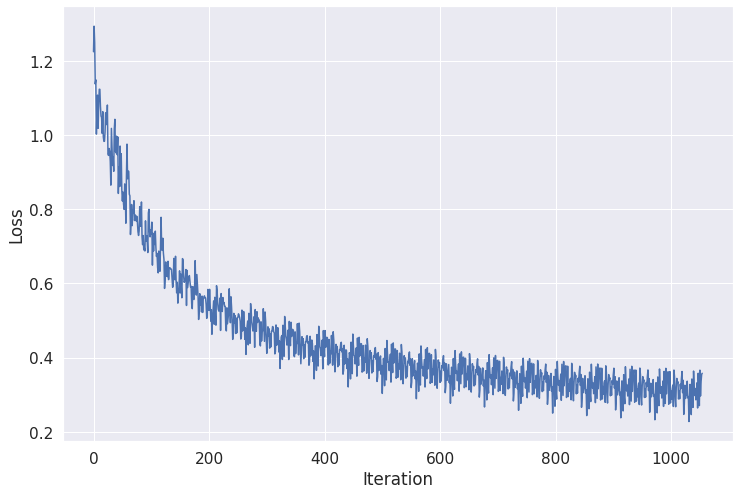

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

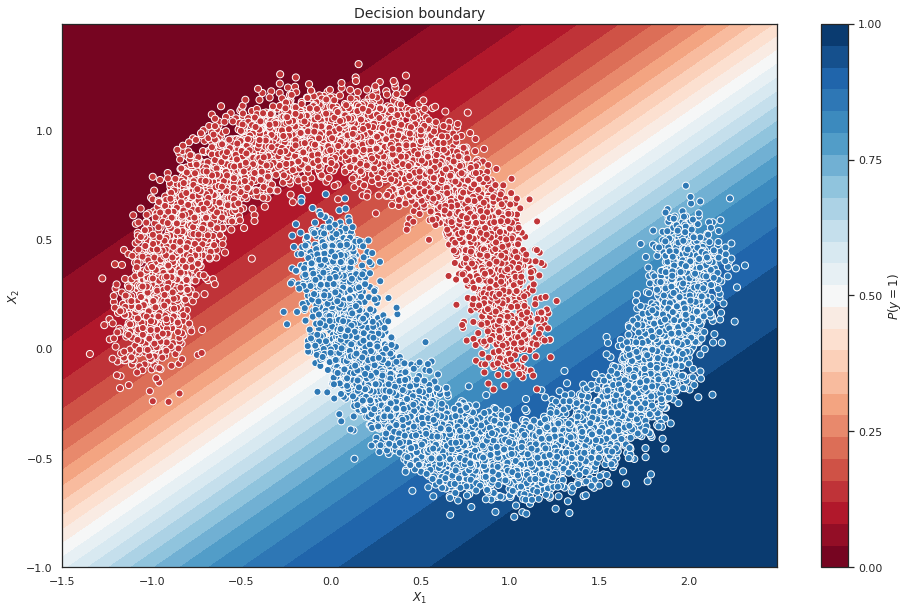

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model.forward(x_batch) #YOUR CODE. Compute predictions
        probabilities = torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score
predictions = predict(val_dataloader, linear_regression) # YOUR CODE. Compute total accuracy
accuracy_score(y_val_t, predictions)

0.4912

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**  0.4912

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'

train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128) # YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=128) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
activation = nn.ELU

In [19]:
model = nn.Sequential(
    nn.Flatten(), #вытянуть изображение в вектор
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10) #YOUR CODE. Add layers to your sequential class
)

In [20]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [21]:
model.to(device)
summary(model, (784,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [22]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds.cpu().detach() == y_batch).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8824333333333333
Loader: valid. Accuracy: 0.9258
Epoch: 2
Loader: train. Accuracy: 0.9426166666666667
Loader: valid. Accuracy: 0.9504
Epoch: 3
Loader: train. Accuracy: 0.9599666666666666
Loader: valid. Accuracy: 0.9529
Epoch: 4
Loader: train. Accuracy: 0.9681833333333333
Loader: valid. Accuracy: 0.9564
Epoch: 5
Loader: train. Accuracy: 0.9737166666666667
Loader: valid. Accuracy: 0.9625
Epoch: 6
Loader: train. Accuracy: 0.9785166666666667
Loader: valid. Accuracy: 0.9698
Epoch: 7
Loader: train. Accuracy: 0.9817333333333333
Loader: valid. Accuracy: 0.9739
Epoch: 8
Loader: train. Accuracy: 0.98385
Loader: valid. Accuracy: 0.9743
Epoch: 9
Loader: train. Accuracy: 0.9853833333333334
Loader: valid. Accuracy: 0.9714
Epoch: 10
Loader: train. Accuracy: 0.9866666666666667
Loader: valid. Accuracy: 0.9579


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [23]:
elu_accuracy = accuracy["valid"]

In [24]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(), #вытянуть изображение в вектор
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10) #YOUR CODE. Add layers to your sequential class
    )
    model.to(device) #модель на GPU
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    # loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train() #режим тренировки
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device)) #input и output модели на GPU
                    loss = criterion(outp, y_batch.to(device)) #метки на GPU для подсчета с output
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval() #режим валидации
                    with torch.no_grad():
                        outp = model(x_batch.to(device))
                preds = outp.argmax(-1)
                correct = (preds.cpu().detach() == y_batch).sum()
                all = len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [25]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8654
Loader: valid. Accuracy: 0.8815
Epoch: 2
Loader: train. Accuracy: 0.89655
Loader: valid. Accuracy: 0.9002
Epoch: 3
Loader: train. Accuracy: 0.9003
Loader: valid. Accuracy: 0.8988
Epoch: 4
Loader: train. Accuracy: 0.9023833333333333
Loader: valid. Accuracy: 0.9013
Epoch: 5
Loader: train. Accuracy: 0.90405
Loader: valid. Accuracy: 0.9011
Epoch: 6
Loader: train. Accuracy: 0.9052
Loader: valid. Accuracy: 0.901
Epoch: 7
Loader: train. Accuracy: 0.9066166666666666
Loader: valid. Accuracy: 0.9006
Epoch: 8
Loader: train. Accuracy: 0.9082
Loader: valid. Accuracy: 0.9014
Epoch: 9
Loader: train. Accuracy: 0.9086666666666666
Loader: valid. Accuracy: 0.902
Epoch: 10
Loader: train. Accuracy: 0.9098333333333334
Loader: valid. Accuracy: 0.9035
Epoch: 1
Loader: train. Accuracy: 0.8688666666666667
Loader: valid. Accuracy: 0.9249
Epoch: 2
Loader: train. Accuracy: 0.9339666666666666
Loader: valid. Accuracy: 0.9481
Epoch: 3
Loader: train. Accuracy: 0.951183333333333

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

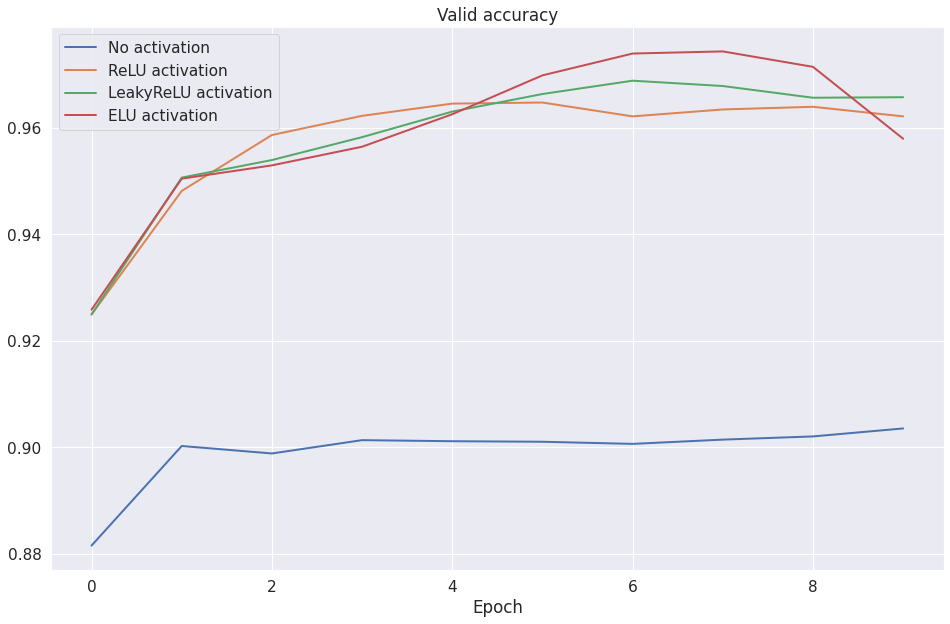

In [26]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

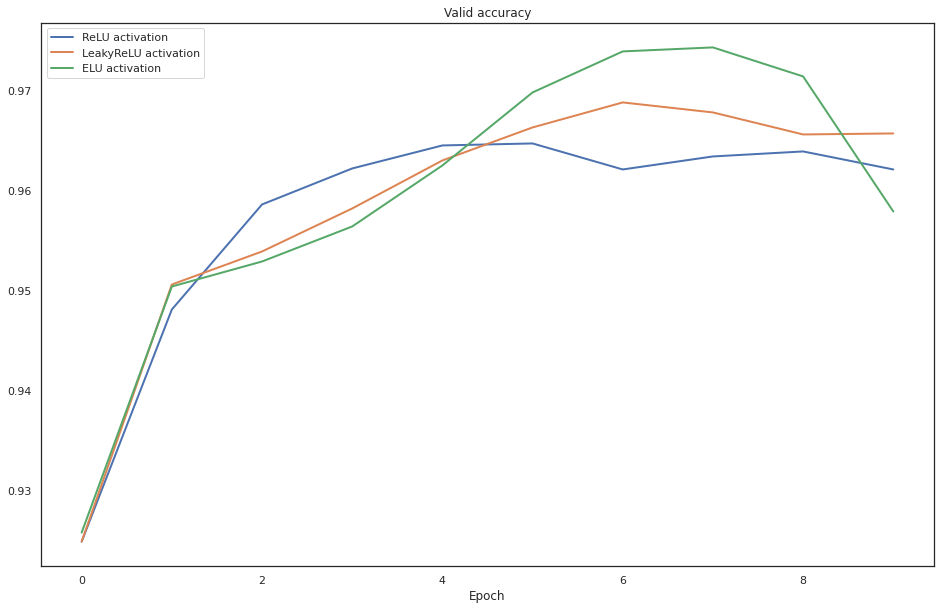

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** nn.ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [28]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-04-28 08:58:51--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-04-28 08:58:52--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   219KB/s    in 0.2s    

2022-04-28 08:58:52 (219 KB/s) - ‘sample_photo.jpg’ saved [49337/4

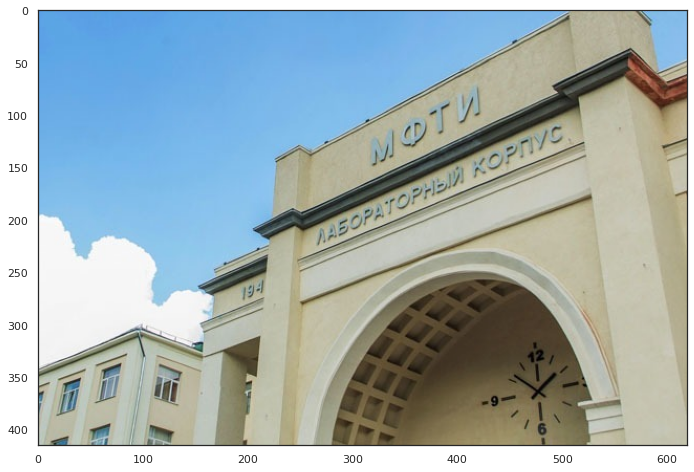

In [29]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [30]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
[1, -2, 1],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


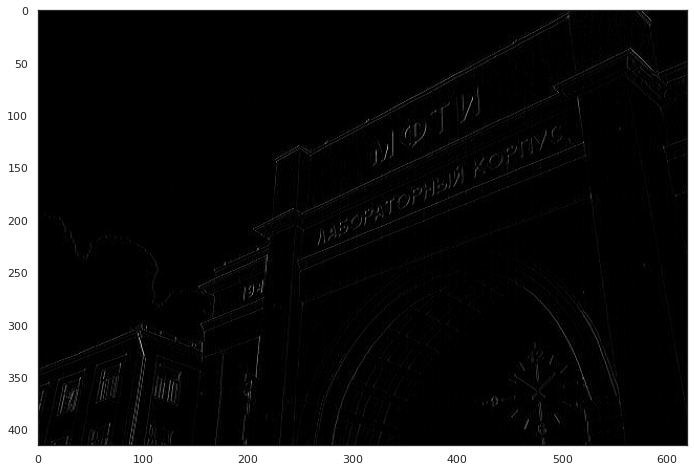

In [31]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А3, Б5, В4, Г6, Д2, Е1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [32]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape) для flatten размерности ниже и для первого линейного слоя 5*5*16
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [33]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [34]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device))
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds.cpu().detach() == y_batch).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8760166666666667
Loader: valid. Accuracy: 0.9623
Epoch: 2
Loader: train. Accuracy: 0.9664
Loader: valid. Accuracy: 0.9726
Epoch: 3
Loader: train. Accuracy: 0.9773
Loader: valid. Accuracy: 0.9782
Epoch: 4
Loader: train. Accuracy: 0.9825
Loader: valid. Accuracy: 0.9824
Epoch: 5
Loader: train. Accuracy: 0.9854833333333334
Loader: valid. Accuracy: 0.9839
Epoch: 6
Loader: train. Accuracy: 0.9878666666666667
Loader: valid. Accuracy: 0.9854
Epoch: 7
Loader: train. Accuracy: 0.9897666666666667
Loader: valid. Accuracy: 0.9856
Epoch: 8
Loader: train. Accuracy: 0.9913333333333333
Loader: valid. Accuracy: 0.9857
Epoch: 9
Loader: train. Accuracy: 0.9924333333333333
Loader: valid. Accuracy: 0.9865
Epoch: 10
Loader: train. Accuracy: 0.9936666666666667
Loader: valid. Accuracy: 0.9866


In [35]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

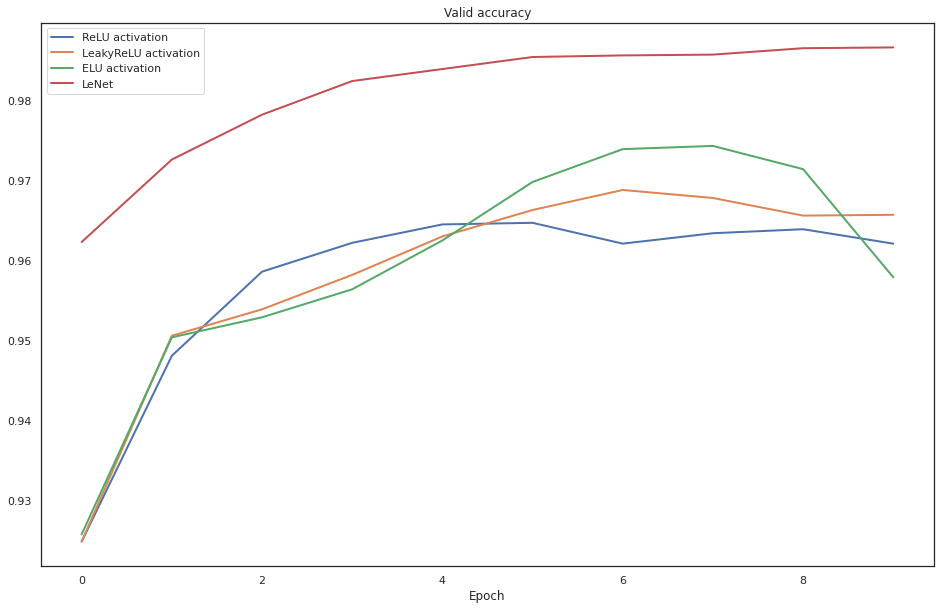

In [44]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99

In [45]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
!cp /content/drive/MyDrive/[homework]dense_and_convolutional_nn.ipynb [homework]dense_and_convolutional_nn.ipynb 

In [50]:
!pwd

/content


In [54]:
!jupyter nbconvert --to PDF "dense_and_convolutional_nn.ipynb"

[NbConvertApp] Converting notebook dense_and_convolutional_nn.ipynb to PDF
[NbConvertApp] Support files will be in dense_and_convolutional_nn_files/
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Making directory ./dense_and_convolutional_nn_files
[NbConvertApp] Writing 124734 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
